In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import squidpy as sq
from sklearn.metrics.pairwise import cosine_similarity
import statistics
import pandas as pd
import json
import pickle
from anndata import AnnData
import pathlib
import skimage
import seaborn as sns
import tangram as tg
from scipy.spatial import distance
import pickle
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import precision_score, recall_score, f1_score

/home/apon/anaconda3/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
adata_st = sc.read_h5ad("voxalized_mfish_for_EM.h5ad")
adata_sc = sc.read_h5ad("../lucas_data/real_st_spapros_merfish.h5ad")

### Load object

In [3]:
class EM_postprocess:
    
    def __init__(self, candidates, adata_sc, adata_st, n_cells_spot, spatial_coords, max_iter, alpha, beta):
        
        self.S = {} #Contains indices of best fitting cells per voxel (index_voxel: [index_cells])
        self.candidates = candidates
        self.adata_sc = adata_sc
        self.adata_st = adata_st
        self.n_cells_spot = n_cells_spot
        self.spatial_coords = spatial_coords
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        
        self.n_voxels = self.adata_st.shape[0]
        
        shared_genes = adata_sc.var_names.intersection(adata_st.var_names, sort=False)
        self.adata_sc_shared_genes = adata_sc[:, adata_sc.var_names.isin(shared_genes)].copy()
        self.adata_st_shared_genes = adata_st[:, adata_st.var_names.isin(shared_genes)].copy()
        
    def _init_candidates(self, v):
        """
        input: one-hot encoded vector
        output: np.array (len <= n_cells_spot) with indices of the selected cells to represent the spot at init
        if n_cells_spot > candidates it returns all the candidates.
        """
        one_indices = np.where(v == 1)[0]
        
        if len(one_indices) >= self.n_cells_spot:
            selected = np.random.choice(one_indices, size=self.n_cells_spot, replace=False)
        else:
            selected = one_indices
    
        return selected
    
    def _get_candidates(self, v):
        """
        Input: one-hot encoded vector
        Output: np.array with the indices of the candidates of a voxel.
        """
        
        return np.where(v == 1)[0]
    
    def _get_neighbors(self, v, radius=350):
        """
        Given a voxel index and a radius, return indices of voxels within radius.
        Output: np.ndarray: Indices of neighboring voxels.
        """
        
        ref_coord = self.spatial_coords[v]

        # Compute Euclidean distances from the reference voxel to all others
        dists = np.linalg.norm(self.spatial_coords - ref_coord, axis=1)

        # Get indices of voxels within the radius (excluding the voxel itself)
        neighbor_indices = np.where((dists > 0) & (dists <= radius))[0]
                
        return neighbor_indices
    
    def _cosine_similarity(self, vec1, vec2):
        """
        Computes cosine similarity between two vectors.
        """
        vec1 = vec1.ravel()
        vec2 = vec2.ravel()
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def _neighbors_similarity(self, vec1, neighbors):
        """
        Vec1 is a vector.
        neighbors is an array containing the index of the neighboring voxels.
        
        This function averages the expression profile of ALL cells in neighboring voxels 
        and then performs cosine similarity between the resulting mean expression vector 
        and our candidate vector.
        """
        neighbor_cells = [cell for n in neighbors for cell in self.S[n]] #list with index of all currently chosen neighbor cells
        mean_neigh_expr = self.adata_sc.X[neighbor_cells].mean(axis=0)
        return self._cosine_similarity(vec1, mean_neigh_expr)
    
    def _compare_S(self, S, S_new):
        """
        Compares if previous selection of cells in all voxels are the same in the new iteration.
        Checks if two dictionaries are identical.
        """
        for key in S:
            if sorted(S[key]) != sorted(S_new[key]):
                return False

        return True
           
    def run_EM(self):
        self.logs = []  # List to store iteration logs
        self.neighbors = dict()

        #----- init -----
        for v in range(self.n_voxels):
            self.S[v] = self._init_candidates(self.candidates[:, v])
            self.neighbors[v] = self._get_neighbors(v, radius=300)

        #----- E-M steps -----
        for iteration in range(self.max_iter):
            S_new = {}
            used_cells = set()  # Track cells already assigned to prevent reuse
            voxel_order = np.random.permutation(self.n_voxels)  # Shuffle voxel update order

            for v in voxel_order:
                candidates = self._get_candidates(self.candidates[:, v])
                available_candidates = [c for c in candidates if c not in used_cells]

                # If no candidates available (all have been used), skip voxel
                if len(available_candidates) == 0:
                    S_new[v] = []
                    continue

                neighbors = self.neighbors[v]
                scores = []

                for c in available_candidates:
                    # E-step: Compute similarity scores
                    vec_c = self.adata_sc_shared_genes.X[c, :] #candidate expr pattern for sim_voxel
                    vec_cc = self.adata_sc.X[c, :] #candidate expr pattern for sim_neighbors

                    sim_voxel = self._cosine_similarity(vec_c, self.adata_st_shared_genes.X[v, :])
                    sim_neighbors = self._neighbors_similarity(vec_cc, neighbors)
                    score = self.alpha * sim_voxel + self.beta * sim_neighbors
                    scores.append(score)

                scores = np.array(scores)
                gamma = np.exp(scores - np.max(scores))  # Softmax normalization
                gamma /= gamma.sum()

                # M-step: Select top-n_cells_spot based on gamma (limited by availability)
                top_idx = np.argsort(gamma)[-min(self.n_cells_spot, len(available_candidates)):]
                selected = [available_candidates[i] for i in top_idx]

                S_new[v] = selected
                used_cells.update(selected)

            # Log progress
            self.logs.append({
                "iteration": iteration,
                "n_voxels_updated": sum(len(v) > 0 for v in S_new.values()),
                "n_cells_used": len(used_cells),
            })

            print(f"Iteration {iteration+1}: {len(used_cells)} cells assigned across {self.n_voxels} voxels.")

            # Check for convergence
            if self._compare_S(self.S, S_new):
                print(f"Converged at iteration {iteration+1}.")
                break

            self.S = S_new
    
    def assess_EM(self):
        """
        Computes the cos sim between the average expr of all cells in a voxel and the expr of the same voxel
        in spatial data.
        
        Computes the cos sim between the mean expr of all cells in a voxel and the mean expr of all neighbor voxels
        in spatial data.
        """
        self.result_vox_sim = []
        self.result_neigh_sim = []

        for v in self.S:
            #Cos sim between our selected cells mean expr and the voxel gene expr
            mean_gene_expr_v = self.adata_sc_shared_genes.X[self.S[v]].mean(axis=0) #mean gene expr of cells in voxel v
            self.result_vox_sim.append(self._cosine_similarity(mean_gene_expr_v, self.adata_st_shared_genes.X[v, :]))
            
            #Cos sim between our selected cells mean expr and neighboring voxels
            neighbors = self.neighbors[v]
            mean_gene_expr_v = self.adata_sc.X[self.S[v]].mean(axis=0)
            self.result_neigh_sim.append(self._neighbors_similarity(mean_gene_expr_v, neighbors))
        
        print("Find results in self.result_vox_sim and self.result_neigh_sim")

In [4]:
with open("results/em_object.pkl", "rb") as f:
    em_post_obj = pickle.load(f)

### EM dictionary keys changed to match those of the ground truth

Goal: compare tg + post processing to ground truth (mfish data)

Problem: after post processing, keys (voxels) in the resulting dictionary didn't match the keys in the dictionary of the ground truth.

We have to adjust the keys for them to match. I chose that both dictionaries have as keys the idx of the voxels in the full voxalized mfish data (so 1 to 579 or whatever). Since subsetting order is preserved, voxel 1 in postprocessing results is equal to the first number of the list of randomly selected voxels (adata_st.uns["selected_voxels"].) 

In [5]:
S = dict(sorted(em_post_obj.S.items()))

# New keys you want to use
new_keys = adata_st.uns["selected_voxels"]

# Step 1: Get values in the same order as the original keys
values = list(S.values())

# Step 2: Zip new keys with original values
EM_dict = dict(zip(new_keys, values))

print(EM_dict)

{555: [1041, 769, 1027, 1274, 741, 1051, 4601, 737, 806], 282: [4609, 498, 1481, 4353, 2032, 1513, 4859, 2124, 2063, 2089], 492: [700, 585], 380: [3403, 3495, 4063, 2273, 3378, 3583, 3469, 5043, 4251, 4591], 28: [1305, 1193, 5082], 46: [1118, 1172, 1196, 1289, 4779], 158: [3088, 5357, 3059, 2817, 3513, 2839, 3938, 3129, 4533, 4305], 59: [3687, 5488, 3365, 3718, 3401, 3655, 4060, 3700, 3712, 3739], 123: [4995, 5344, 3163, 5578, 3662, 4373, 3614, 1863, 3596, 3604], 344: [4707, 5168, 1012, 1841, 3023, 4333, 2977, 3191, 3111, 3192], 311: [4546, 4441, 1345, 2152, 2691, 2569, 2667, 2733, 2601], 22: [2318, 1681, 1140, 4, 1191], 339: [570, 742, 766, 1207, 1399, 1446, 1491, 1738, 1824, 4550], 499: [582, 552, 547, 459, 440, 434, 429, 417, 4927, 5200], 194: [225], 102: [3335, 4969, 1597, 2483, 1803, 3321, 3295, 3372, 3292, 4241], 137: [5668, 5304, 5634, 329, 4937, 220, 5633, 184, 153, 4256], 577: [1969, 2303, 1777, 4777, 2076, 839, 859, 4544, 956, 935], 108: [5312, 316, 293, 277, 275, 257, 253, 2

### Populate the dictionary of ground truth; voxel: cell idx

In [6]:
truth = dict()

#init dict with chosen voxels respecting order:

for i in adata_st.uns["selected_voxels"]:
    truth[i] = []

for i in range(len(adata_sc.obs["pseudo_spot"])): #iterate through each cell
    if adata_sc.obs["pseudo_spot"][i] in adata_st.uns["selected_voxels"]: #check if voxel of cell has been selected
        truth[adata_sc.obs["pseudo_spot"][i]].append(i) # apend cell idx to a voxel that was chosen 



In [7]:
truth = dict(sorted(truth.items()))

In [8]:
truth.keys()==EM_dict.keys()

True

### voxel expr cosine similarity

Just a sanity check as gene expression similarity is used in EM to select the best candidates for each voxel.

In [9]:
expr_cos_sim = []


for i in adata_st.uns["selected_voxels"]:
    a = adata_sc.X[EM_dict[i]].mean(axis=0)
    b = adata_sc.X[truth[i]].mean(axis=0)

    if np.isnan(a).any() or np.isnan(b).any():
        expr_cos_sim.append(np.nan)  # Or continue if you want to skip
        continue

    sim = cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0]
    expr_cos_sim.append(sim)
    
    

# Assessing performance of EM

In [10]:
def compute_per_voxel_metrics(S_true, S_pred):
    """
    Compute per-voxel precision, recall, and F1 score.
    Returns a dictionary with voxel-wise metrics.
    """
    voxel_ids = list(S_true.keys())
    
    precision_list = []
    recall_list = []
    f1_list = []

    for v in voxel_ids:
        true_cells = set(S_true.get(v, []))
        pred_cells = set(S_pred.get(v, []))
        
        tp = len(true_cells & pred_cells)
        fp = len(pred_cells - true_cells)
        fn = len(true_cells - pred_cells)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return {
        "voxels": voxel_ids,
        "precision": np.array(precision_list),
        "recall": np.array(recall_list),
        "f1": np.array(f1_list),
    }


In [11]:
def plot_voxel_metrics(metrics_dict):
    voxels = metrics_dict["voxels"]
    precision = metrics_dict["precision"]
    recall = metrics_dict["recall"]
    f1 = metrics_dict["f1"]

    # Violin plot
    data = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    df = sns.load_dataset("iris")  # placeholder to setup seaborn
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Violin plot
    sns.violinplot(data=list(data.values()), ax=axs[0])
    axs[0].set_xticks(range(len(data)))
    axs[0].set_xticklabels(data.keys())
    axs[0].set_title("Per-voxel Precision / Recall / F1 Distribution")

    # Scatter plot: Precision vs. Recall
    axs[1].scatter(precision, recall, alpha=0.6, c=f1, cmap="viridis", s=30)
    axs[1].set_xlabel("Precision")
    axs[1].set_ylabel("Recall")
    axs[1].set_title("Precision vs. Recall per Voxel (color = F1)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


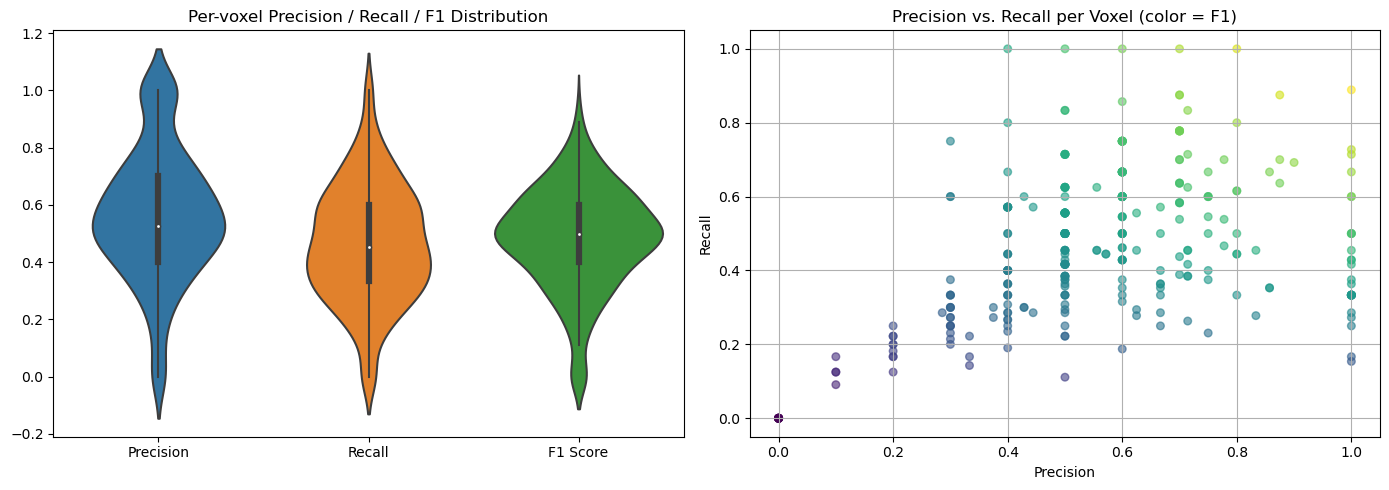

Mean Precision: 0.5609828042328043
Mean Recall: 0.4635546681274235
Mean F1 Score: 0.48515468646805954


In [12]:
metrics = compute_per_voxel_metrics(S_true = truth, S_pred=EM_dict)
plot_voxel_metrics(metrics)

print("Mean Precision:", np.mean(metrics["precision"]))
print("Mean Recall:", np.mean(metrics["recall"]))
print("Mean F1 Score:", np.mean(metrics["f1"]))

# Now we compare Tg performance

In [22]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="cells",
    density_prior='rna_count_based',
    lambda_d = 0.89,
    lambda_g2 = 0.99,
    num_epochs=500,
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 100 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.499, VG reg: 0.605, KL reg: 0.148
Score: 0.992, VG reg: 0.997, KL reg: 0.001
Score: 0.994, VG reg: 0.998, KL reg: 0.001
Score: 0.995, VG reg: 0.998, KL reg: 0.001
Score: 0.995, VG reg: 0.998, KL reg: 0.001


INFO:root:Saving results..


In [24]:
ad_map.X.shape

(5793, 300)

In [23]:
(ad_map.X>0.72).sum() #total number of cells placed in voxels by tg

2479

In [29]:
# We will select the cells mapped with high probability to each voxel
tg_dict = dict()

for i in range(ad_map.X.shape[1]):
    indices = list(np.where(ad_map.X[:, i] > 0.72)[0])
    tg_dict[adata_st.uns["selected_voxels"][i]] = indices

In [30]:
tg_dict

{555: [737, 741, 4601],
 282: [2032, 2063, 2089, 2124, 4353, 5561],
 492: [579, 585, 700],
 380: [72,
  1238,
  1461,
  1858,
  3378,
  3424,
  3469,
  3495,
  3528,
  3575,
  3583,
  4194,
  4270,
  4467,
  4527,
  4591,
  5043,
  5136,
  5463,
  5477,
  5639,
  5656,
  5662,
  5711,
  5767,
  5786],
 28: [1193, 1305, 5082],
 46: [1118, 1172, 1196, 1289, 4779],
 158: [933, 2817, 3059, 3088, 3129, 3938, 4212, 4305, 4460, 4533, 5240],
 59: [1655,
  3011,
  3569,
  3677,
  3687,
  3700,
  3718,
  3739,
  4210,
  4462,
  4761,
  4861,
  5674],
 123: [2101, 2876, 3596, 3604, 3638, 3662, 3676, 3705, 5344],
 344: [911, 1012, 1841, 2977, 3023, 3111, 3191, 3192, 4577, 4636, 4672],
 311: [2569, 2601, 2691, 2733, 4441, 4546],
 22: [4, 302, 1150, 1191],
 339: [75, 166, 1399, 1446, 4550],
 499: [429,
  434,
  459,
  486,
  552,
  582,
  618,
  639,
  1180,
  4453,
  4477,
  4517,
  4914,
  4927],
 194: [225],
 102: [1597, 3292, 3321, 3335, 3372, 4241],
 137: [153, 184, 220, 4256, 4717, 5519, 5633,

### number of cells in EM_dict

In [18]:
values = list(EM_dict.values())
flat = [item for sublist in values for item in sublist]
len(flat) 

2487

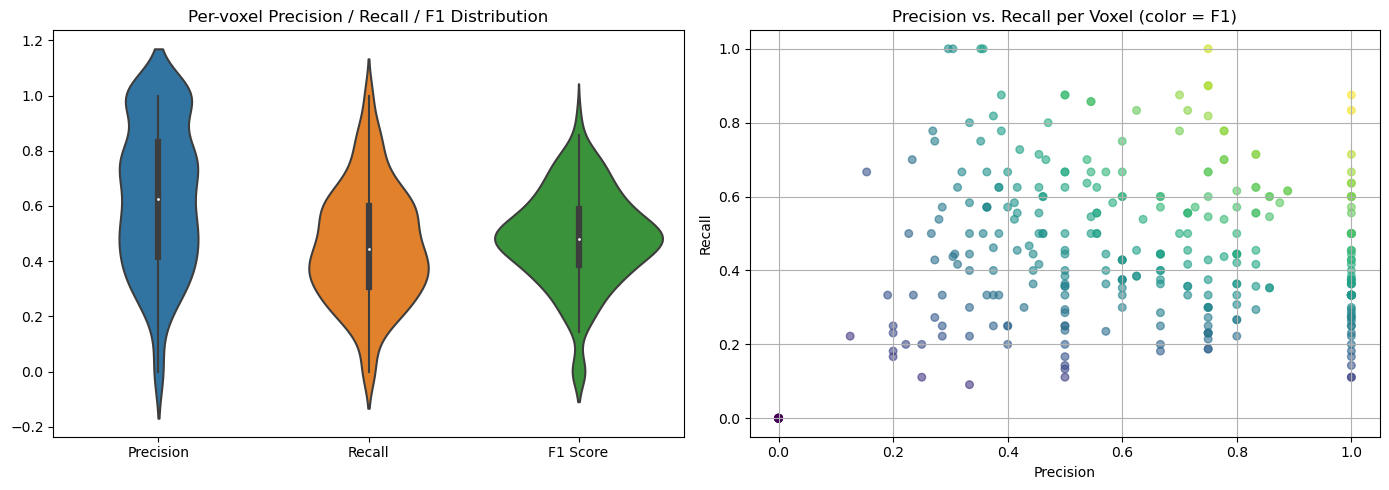

Mean Precision: 0.6278973758935675
Mean Recall: 0.45539825957782604
Mean F1 Score: 0.48340364431873506


In [31]:
metrics_tg = compute_per_voxel_metrics(S_true = truth, S_pred=tg_dict)
plot_voxel_metrics(metrics_tg)

print("Mean Precision:", np.mean(metrics_tg["precision"]))
print("Mean Recall:", np.mean(metrics_tg["recall"]))
print("Mean F1 Score:", np.mean(metrics_tg["f1"]))